# 3. Data Modeling

## 3.1 Import Data

**Analysis Questions:**

Q1. From a traveler's perspective, does a "superhost" enhance the guest experience?

Q2. What features have the most influence on the success and profitability of an Airbnb listing from an investor's standpoint?

Q3. What are the main reasons people leave bad reviews?

In [1]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter(action='ignore')

import statsmodels.stats.multitest as multi

import func

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)

In [2]:
# Import cleaned dataframes
df_listings = pd.read_pickle('../data/listings.pkl')
df_reviews = pd.read_pickle('../data/reviews.pkl')

In [3]:
# One-hot encode catagory features
cat_cols = df_listings.select_dtypes('category').columns.tolist()

for col in cat_cols:
    dummies = pd.get_dummies(df_listings[col], prefix=col)
    df_listings = pd.concat([df_listings, dummies], axis=1)
    df_listings.drop(col, axis=1,inplace=True)

In [4]:
# Merge data
df_reviews.listing_id = df_reviews.listing_id.astype('str')
df_full = df_listings.merge(df_reviews, left_on='id', right_on='listing_id')

# drop id
df_listings.drop('id', axis=1, inplace=True)

## 3.2 From a traveler's perspective, does a "superhost" enhance the guest experience?

In [5]:
# Calculate feature p values
group = 'host_is_superhost'
num_cols = df_listings.select_dtypes(exclude=['object']).columns
test_results = []

for col in num_cols:
    if col=="host_is_superhost":
        continue
    else:
        test_results.append(func.bootstrap_t_pvalue(df_listings, group, col, B=5000)) #Lower B to increase speed

# Display the t-test result
test_results = pd.DataFrame(test_results,columns=['feature','pvalue','statistics'])

In [6]:
# plot signifigance
multitest_result = multi.multipletests(test_results.pvalue,method="bonferroni")
test_results['significant'],test_results['adjusted_pvalue']=multitest_result[0],multitest_result[1]
test_results.sort_values(['significant','pvalue'],ascending=[False,True]).style.bar(subset='statistics', align='zero', color=['#d65f5f', '#5fba7d'])

,feature,pvalue,statistics,significant,adjusted_pvalue
1,host_response_rate,0.000000,14.092996,True,0.000000
3,host_has_profile_pic,0.000000,2.452137,True,0.000000
4,host_identity_verified,0.000000,7.996837,True,0.000000
17,extra_people,0.000000,4.115656,True,0.000000
20,number_of_reviews,0.000000,10.096419,True,0.000000
21,review_scores_rating,0.000000,23.963470,True,0.000000
22,review_scores_accuracy,0.000000,21.528450,True,0.000000
23,review_scores_cleanliness,0.000000,20.308684,True,0.000000
24,review_scores_checkin,0.000000,17.516334,True,0.000000
25,review_scores_communication,0.000000,18.979648,True,0.000000


In [7]:
# What % of statistically significant features are amenities?
test_results.feature[test_results.significant==True].str.contains('amenity').sum()/np.sum(test_results.significant==True)

0.4864864864864865

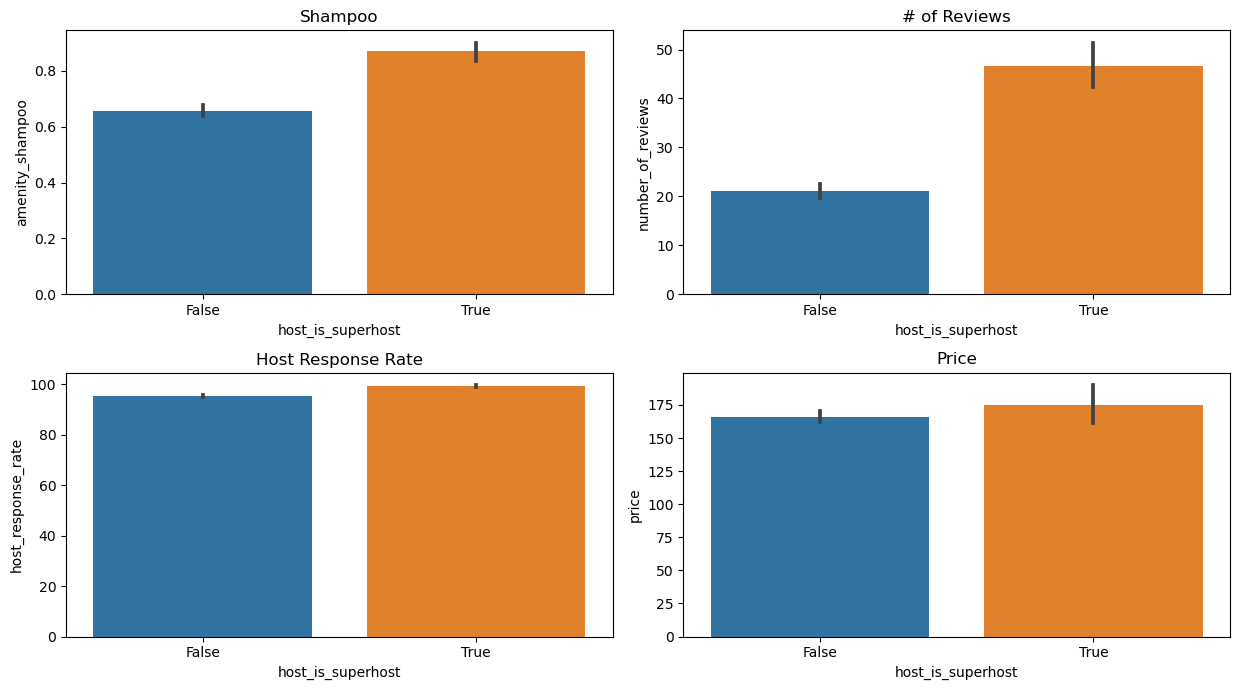

In [8]:
# Explore significant features
plt.subplots(figsize=(12.5, 7))

plt.subplot(221)
sns.barplot(data=df_listings,y="amenity_shampoo",x="host_is_superhost")
plt.title("Shampoo")

plt.subplot(222)
sns.barplot(data=df_listings,y="number_of_reviews",x="host_is_superhost")
plt.title("# of Reviews")

plt.subplot(223)
sns.barplot(data=df_listings,y="host_response_rate",x="host_is_superhost")
plt.title("Host Response Rate")

plt.subplot(224)
sns.barplot(data=df_listings,y="price",x="host_is_superhost")
plt.title("Price")
plt.tight_layout();


**Do "superhosts" enhance the guest experience?**

In comparing super hosts to others, amenities stood out as key differences. Surprisingly, 47% of significant features were amenities. Most of the ameneties that made the cut had to do with convenience and safety for short-term stays, like 'wireless_internet', 'free_parking', 'smoke_detector', 'essentials', and 'shampoo'. Amenities like fireplace, doorman, kitchen, and gym weren't important. I guess people aren't trying to stay fit on vacation lol.

When analyzing some of the significant features more closely we saw a couple of insights. 

Super hosts often get more and better reviews than other hosts, likely because they respond quickly and focus on safety, including verifying themselves and their guests on various platforms. And despite the high quality of super hosts' properties, they don't necessarily charge more. 

To conclude, the answer to are first question is a clear yes! Booking with super hosts can give you a better stay without extra costs. That means they're likely in higher demand and you should book them earlier.

## 3.3 What features have the most influence on the success of an Airbnb listing from an investor's standpoint?

In [9]:
# Create the metric and named it "performance"
df_listings['performance'] = df_listings.reviews_per_month * df_listings.review_scores_rating 

# Drop host and review related features
drop_features = [f for f in df_listings.columns.values if 'review' in f or 'host' in f]

In [10]:
X = df_listings.drop(drop_features+['performance'], axis=1).select_dtypes(exclude='object')
y = df_listings.performance

In [11]:
model, X_train, X_test, y_train, y_test = \
    func.create_regression_mod(X, y)

# Score model
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print("r-squared score was {} on {} training values".format(train_score, X_train.shape[0]))
print("r-squared score was {} on {} test values".format(test_score, X_test.shape[0]))

r-squared score was 0.3126648242658724 on 1897 training values
r-squared score was 0.23016557064806187 on 813 test values


In [12]:
### Get feature coefficients
coef_df = func.coef_weights(model.coef_, X_train)

In [13]:
coef_df.sort_values('abs_coefs',ascending=False).head(20).style.bar(subset='coefs', align='zero', color=['#d65f5f', '#5fba7d'])

,est_int,coefs,abs_coefs
11,minimum_nights,-236.574728,236.574728
2,accommodates,192.065905,192.065905
12,maximum_nights,184.309179,184.309179
6,price,-164.547807,164.547807
1,longitude,142.756166,142.756166
7,weekly_price,-119.069286,119.069286
4,bedrooms,-115.241679,115.241679
64,property_type_Other,-108.788041,108.788041
14,instant_bookable,105.163561,105.163561
16,require_guest_phone_verification,-95.986835,95.986835


By looking at the feature coefficients, we find that certain amenities like Air Conditioning and 24 hour checkins positively affected an Airbnb unit's appeal. On the other hand, doormans were surprisingly unfavorable. But maybe this was due to buildings with doormen tending to be in unfavorable downtown locations.

With friends that live in Boston and Cambridge, I can safely say the north side of the city by the airport isn't where you want to spend your time. On the other hand, Coolidge Corner is a really quaint little place to stay. And Cambridge is a blast. The data interestingly shows that properties in the northwestern part are more desirable, hinted at by the positive values for longitude and latitude coefficients. This is even backed up by crime rates data for Boston, which show less crime occurs in the northwest.

So, for Q2, it's better to skip the northwest areas when looking for places in Boston. Focus on downtown locations, which are more likely to have perks like Air conditioning. And avoid boat properties.

## 3.4 What are the main reasons people leave bad reviews?

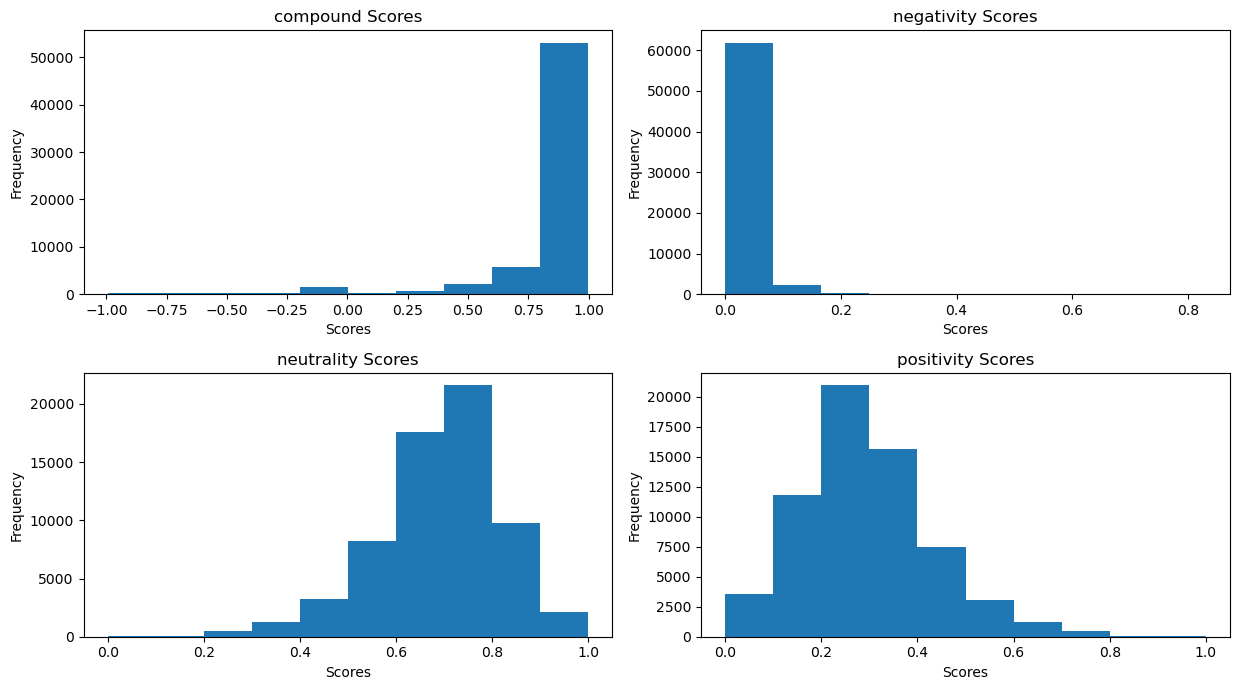

In [14]:
# Store sentiment scores for each comment in dataframe
# Using sample slice of df_reviews for speed performance
df_scores = func.get_sentiment_scores(df_reviews[:], 'comments', plot=True)

In [15]:
# Proportion of reviews with compound scores greater than 0
df_scores.query('compound > 0').shape[0]/df_scores.shape[0]

0.962909995336546

After playing around with filtering the various sentiment scores, negative compound scores reveal the worst reviews, as opposed to low negativity. Since there is some variability, I reviewed comments for compounds ranging from 0 to -0.2 and it looks like a majority of comments with compound less than -0.15 are truly negative reviews. We can filter the data using this information to further explore the frequency of words appearing in negative reviews. 

In [16]:
# Review sentiment scores to determine approach for segmenting bad reviews
df_scores.query('compound < -.15').sort_values('compound').tail(25)
df_scores['comments'][1978]

'This host is very organized and accommodating. She walked us through her book of things to do and went out of her way to meet us at the door even when our flight was delayed late into the night.  The room is in the basement and unfortunately, does smell a bit of cat pee. Once the window is open, it helps air flow. '

In [17]:
# Clean comments
clean_all_comments = df_scores.copy()
clean_all_comments.comments = clean_all_comments.comments.apply(func.clean_string)

In [18]:
# Get negative reviews w/ stop words removed
neg_comments = clean_all_comments.query('compound < -.15').query('negativity > positivity')['comments']

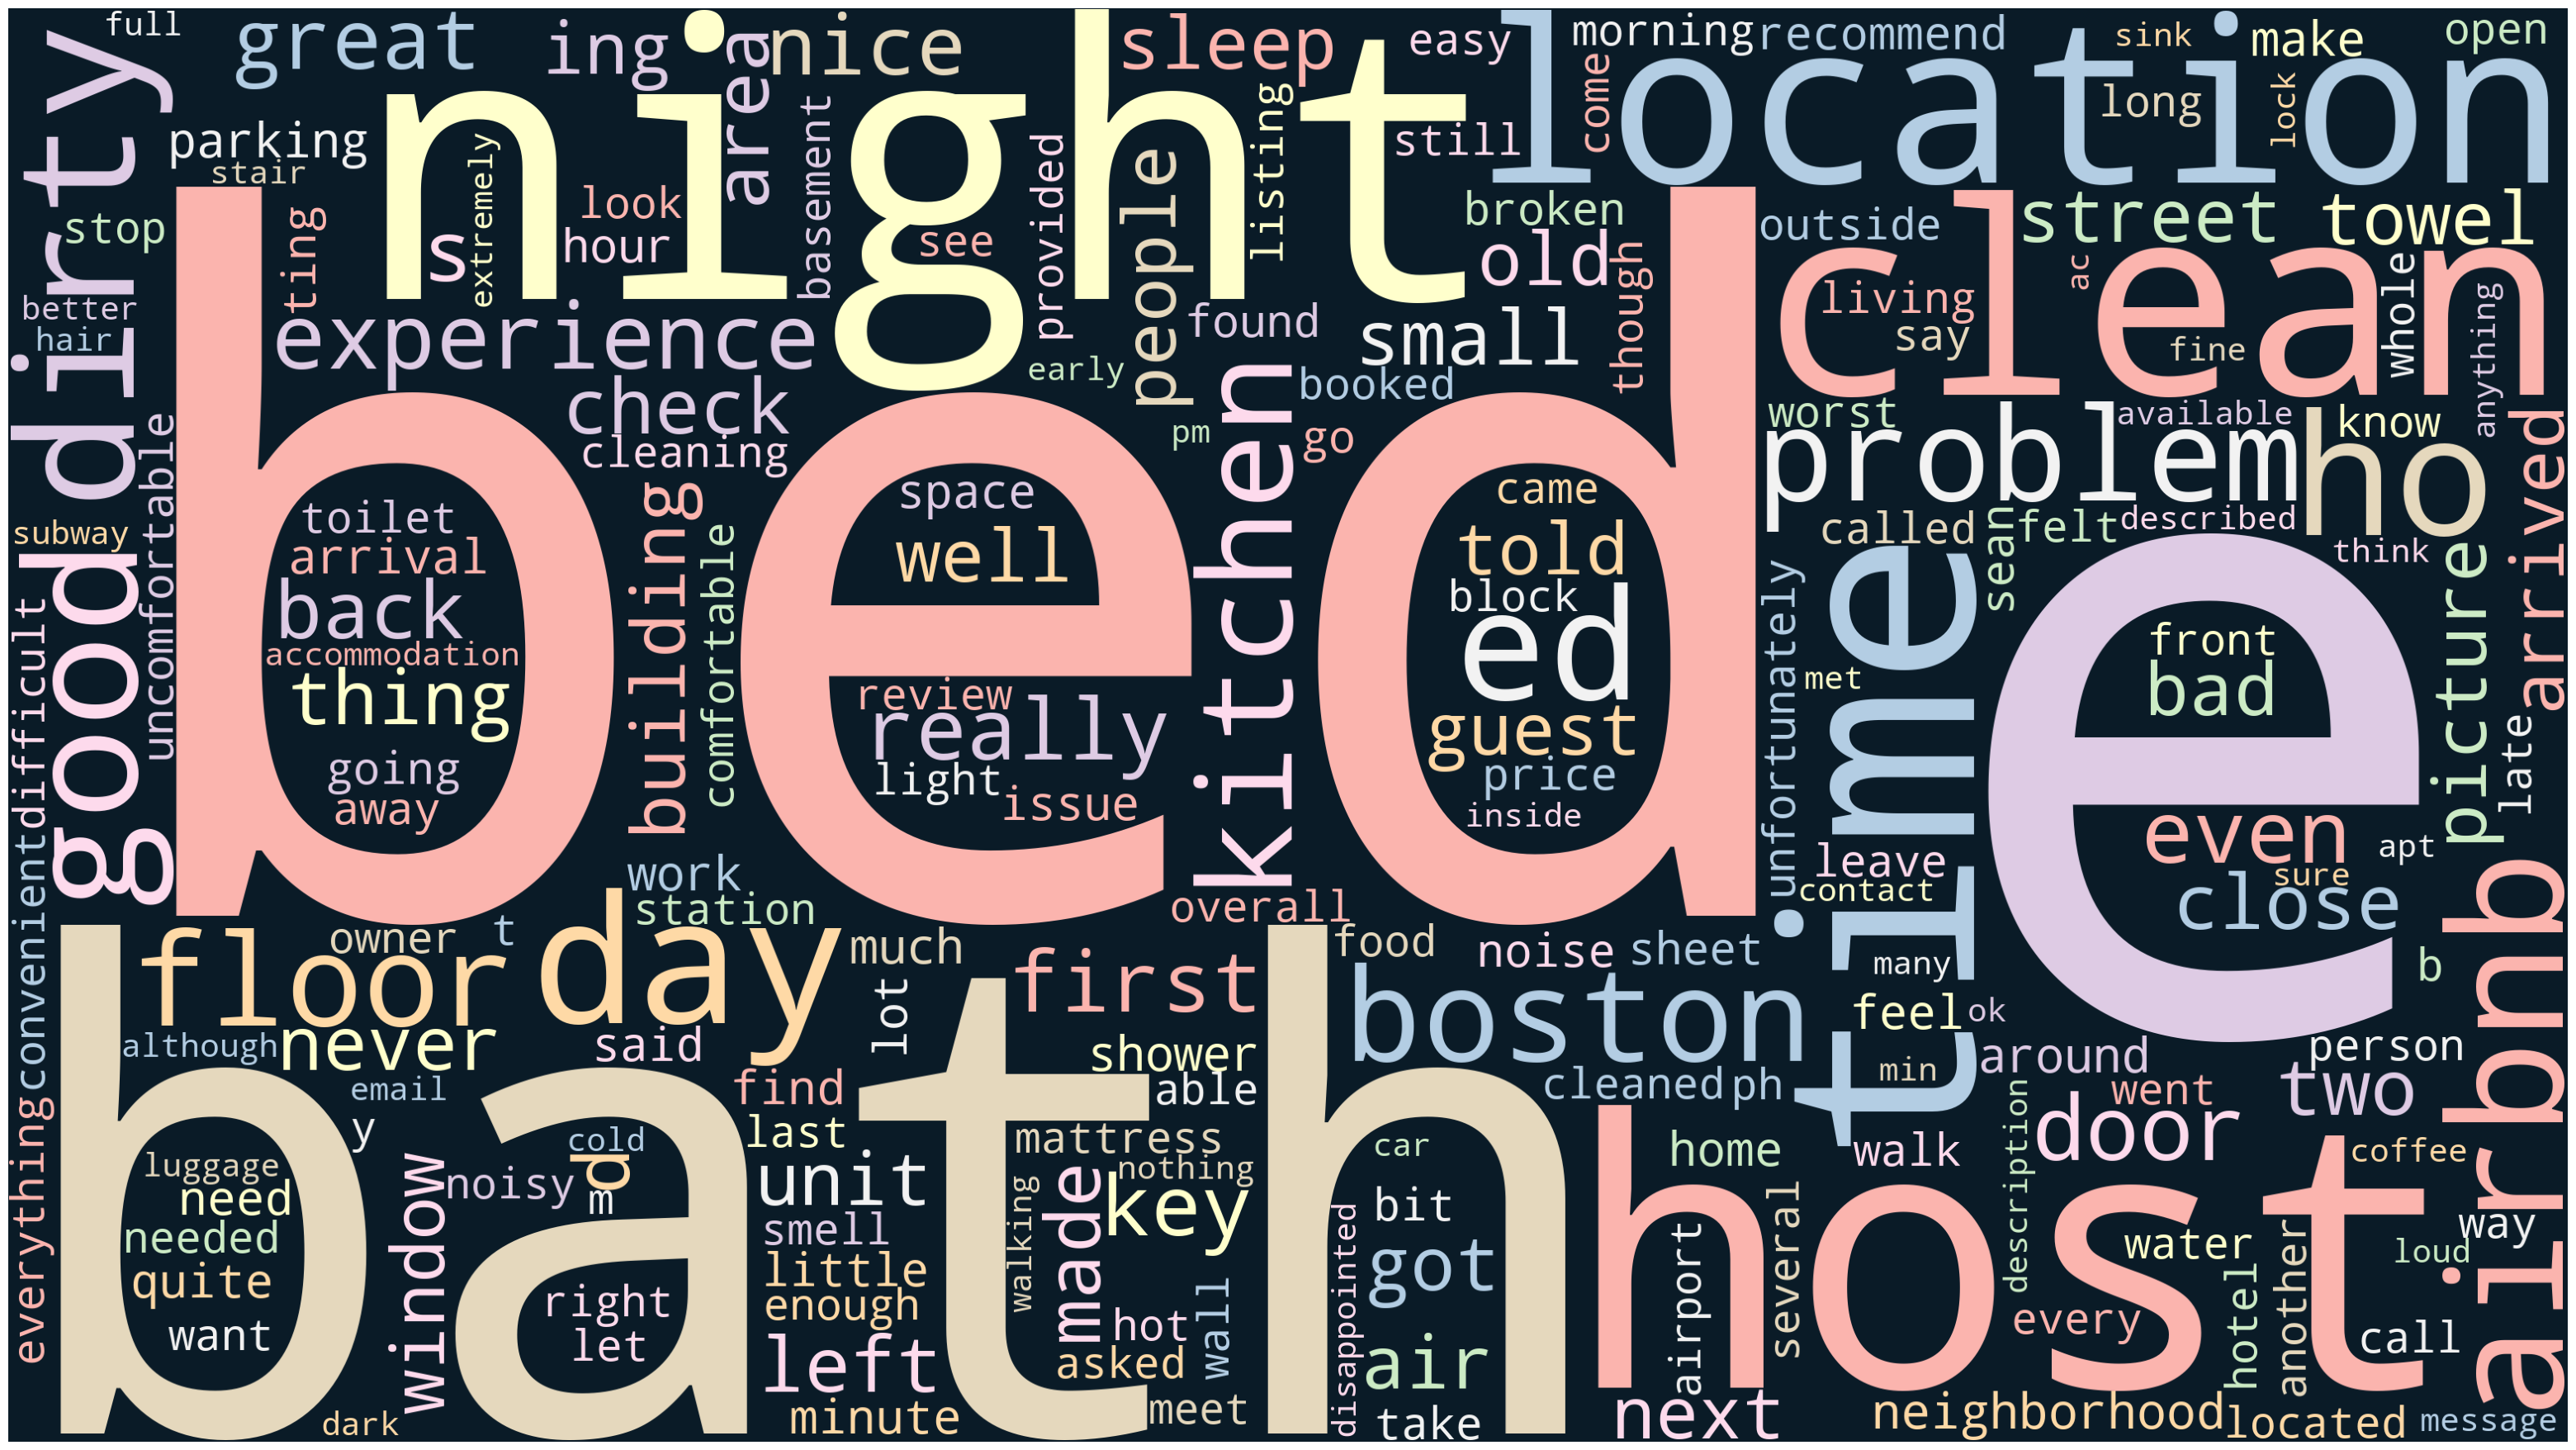

In [37]:
### Plot wordcloud
# join str lists from clean_neg_comments
new_stop_words = ['apartment', 'room', 'place', 'would', 'stay', 'us', 'get', 'also', 'could', 'one']

cloud_text = " ".join(s for s in neg_comments.apply(lambda x: ' '.join(x)))

for word in new_stop_words:
    cloud_text = cloud_text.replace(word, ' ')

# Generate word cloud with a light background
wordcloud = WordCloud(width= 3125, height = 1750, random_state=1, background_color='#0A1B27', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(cloud_text)

# Set figure size
plt.figure(figsize=(40, 30))

# Display image
plt.imshow(wordcloud) 

# No axis details
plt.axis("off");

plt.savefig('../images/neg_wordcloud', bbox_inches='tight')

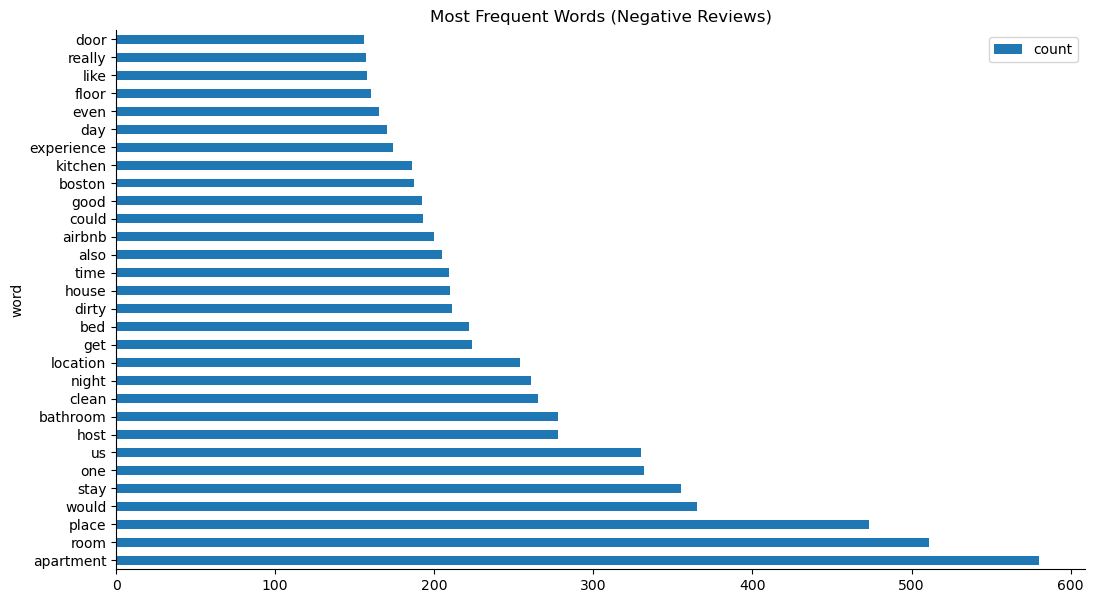

<Figure size 640x480 with 0 Axes>

In [25]:
### Plot top word counts (negative comments)
neg_word_counts = func.count_words(neg_comments)
title = 'Most Frequent Words (Negative Reviews)'
func.plot_most_bar(neg_word_counts, 'word', 'count', title, max=30)S

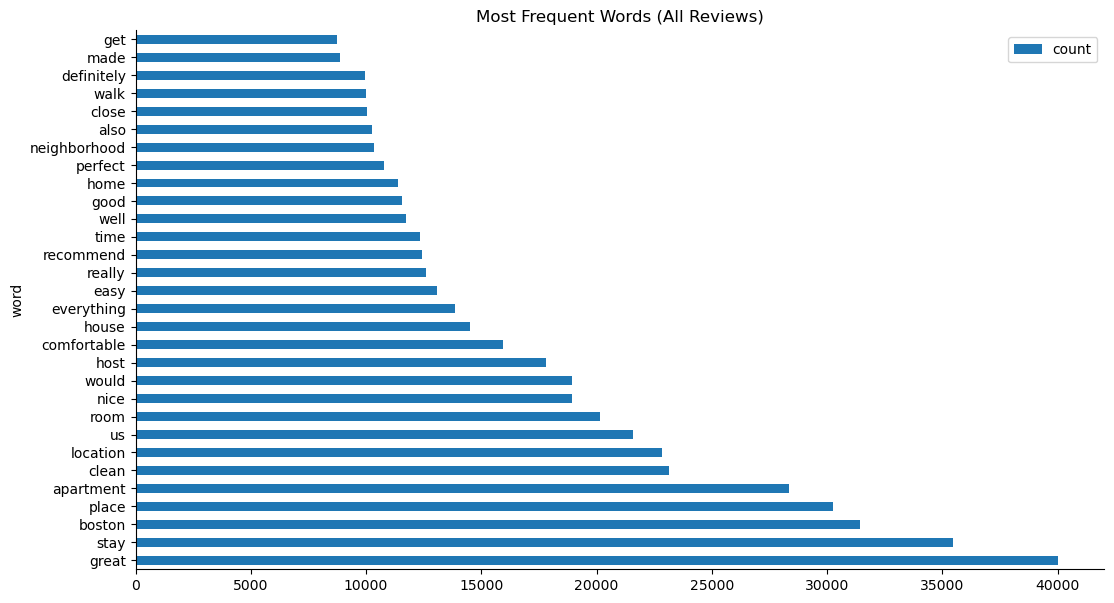

<Figure size 640x480 with 0 Axes>

In [26]:
### Plot top word counts (all comments)
all_word_counts = func.count_words(clean_all_comments['comments'])
title = 'Most Frequent Words (All Reviews)'
func.plot_most_bar(all_word_counts, 'word', 'count', title, max=30)
plt.savefig('../images/all_words')

In [22]:
df_scores.sort_values('compound')['comments'][df_scores['comments'].str.contains('bathroom')]
df_scores['comments'][12511]

"My mum and I stayed here for about a week. We just wanted to start of by saying that we aren't crazy and high demanding people. First, we booked this room but the owner was about to let us stay downstairs in an uglier room without asking us. Second, the apartment had an uncomfortable odor that we had to buy candles on the first night there because we couldn't stand the smell. Also, the kitchen was dirty, and both the floor and bed were dusty. The bathroom was a mess with random things made as decorations. The owner didn't give us enough toilet papers to use so we had to use tissues and napkins. At night, it got so dark that we couldn't be able to see so when we left the apartment in the afternoon, we had to leave the lights in the hallway on. The owner was uncomfortable with that which was just ridiculous. We've been to so many Airbnb apartments with the same price before and they were all much higher quality. We will not recommend this place at all. It was the worst experience of Air